In [ ]:
# Brightness drift levels
brightness_deltas = [0.05, 0.10, 0.15]
print("Brightness drift levels:", brightness_deltas)

Brightness drift levels: [0.05, 0.1, 0.15]


In [ ]:
import os

BASE = "/content/drive/MyDrive/MEDICAL/InfoTheo_dataset"
DRIFT_ROOT = os.path.join(BASE, "drifted_images_brightness")
os.makedirs(DRIFT_ROOT, exist_ok=True)

for delta in brightness_deltas:
    tag = f"brightness_{int(delta*100):03d}"  # e.g. brightness_005
    folder = os.path.join(DRIFT_ROOT, tag, "imagesTs")
    os.makedirs(folder, exist_ok=True)
    print("Will write drifted images to:", folder)

Will write drifted images to: /content/drive/MyDrive/MEDICAL/InfoTheo_dataset/drifted_images_brightness/brightness_005/imagesTs
Will write drifted images to: /content/drive/MyDrive/MEDICAL/InfoTheo_dataset/drifted_images_brightness/brightness_010/imagesTs
Will write drifted images to: /content/drive/MyDrive/MEDICAL/InfoTheo_dataset/drifted_images_brightness/brightness_015/imagesTs


In [ ]:
!pip install surface-distance

In [ ]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
from surface_distance import metrics
from scipy.stats import spearmanr, pearsonr
import scipy.ndimage as ndi

BASE = "/content/drive/MyDrive/MEDICAL/InfoTheo_dataset"

RAW_DS_DIR    = os.path.join(BASE, "nnUNet_raw", "Dataset001_BraTS2020")
IMAGES_TR_DIR = os.path.join(RAW_DS_DIR, "imagesTr")
LABELS_TR_DIR = os.path.join(RAW_DS_DIR, "labelsTr")

PRED_ROOT      = os.path.join(BASE, "nnUNet_predictions")
PRED_CLEAN_DIR = os.path.join(PRED_ROOT, "Dataset001_BraTS2020_test_clean")

TEST_IDS_FILE = "/content/test_ids.txt"
with open(TEST_IDS_FILE, "r") as f:
    test_ids = [l.strip() for l in f.readlines() if l.strip()]

len(test_ids), test_ids[:5]


(56,
 ['BraTS20_Training_053',
  'BraTS20_Training_292',
  'BraTS20_Training_369',
  'BraTS20_Training_100',
  'BraTS20_Training_276'])

Generate a smooth multiplicative bias field

draw 3D Gaussian noise

smooth with a big Gaussian kernel → low-frequency field

normalise to zero mean and unit std

scale by beta and shift to 1.0

apply only inside brain (vol > 0)

same field applied to all 4 modalities (mimicking coil bias)

In [ ]:
def generate_bias_field(shape, beta, rng=None, sigma_factor=0.15):
    """
    Generate a smooth multiplicative bias field for a 3D volume.

    shape: (H, W, D)
    beta:  amplitude parameter, e.g. 0.3 → +/- ~30% variation
    sigma_factor: fraction of each dimension used as Gaussian sigma
    """
    if rng is None:
        rng = np.random.RandomState()

    H, W, D = shape
    # random noise
    field = rng.normal(0.0, 1.0, size=(H, W, D)).astype(np.float32)
    # smooth to low frequency
    sigma = (H * sigma_factor, W * sigma_factor, D * sigma_factor)
    field = ndi.gaussian_filter(field, sigma=sigma, mode="reflect")

    # normalise to zero mean, unit std
    field -= field.mean()
    std = field.std() + 1e-8
    field /= std

    # scale and shift to get multiplicative factor ~ 1 +/- beta
    field = 1.0 + beta * field  # mean ~1, std ~beta
    # clip extremes to avoid crazy values
    field = np.clip(field, 1.0 - 2*beta, 1.0 + 2*beta)

    return field.astype(np.float32)


Apply to a 4-channel case:

In [ ]:
def apply_bias_field_drift_raw_brain_only(imgs_raw, beta, rng=None):
    """
    imgs_raw: (4, H, W, D)
    beta: bias amplitude (0.2, 0.4, ...)
    Applies a smooth multiplicative bias field only inside brain (vol > 0).
    Same field for all modalities.
    """
    if rng is None:
        rng = np.random.RandomState()

    _, H, W, D = imgs_raw.shape
    bias_field = generate_bias_field((H, W, D), beta, rng=rng)

    drifted = np.zeros_like(imgs_raw, dtype=np.float32)
    for m in range(imgs_raw.shape[0]):
        vol = imgs_raw[m].astype(np.float32)
        out = vol.copy()
        mask = vol > 0
        out[mask] = vol[mask] * bias_field[mask]
        drifted[m] = out
    return drifted


Deterministic per case + beta:

In [ ]:
import hashlib

def case_beta_seed(case_id, beta, kind="bias"):
    key = f"{case_id}_{kind}_{beta}".encode("utf-8")
    return int(hashlib.md5(key).hexdigest(), 16) % (2**32)


In [ ]:
def load_case(case_id):
    channels = []
    for c in range(4):
        img_path = os.path.join(IMAGES_TR_DIR, f"{case_id}_{c:04d}.nii.gz")
        img_nii = nib.load(img_path)
        img = img_nii.get_fdata().astype(np.float32)
        channels.append(img)
    imgs = np.stack(channels, axis=0)  # (4, H, W, D)

    label_path = os.path.join(LABELS_TR_DIR, f"{case_id}.nii.gz")
    label = nib.load(label_path).get_fdata().astype(np.int16)
    return imgs, label


Create and save bias-field drifted images for test set

In [ ]:
DRIFT_BIAS_ROOT = os.path.join(BASE, "drifted_images_bias")
os.makedirs(DRIFT_BIAS_ROOT, exist_ok=True)

bias_betas = [0.2, 0.4, 0.6]  # we can adjust

def save_drifted_case_raw(case_id, imgs_drift_raw, output_imagesTs_dir):
    os.makedirs(output_imagesTs_dir, exist_ok=True)
    for c in range(4):
        src_path = os.path.join(IMAGES_TR_DIR, f"{case_id}_{c:04d}.nii.gz")
        src_nii = nib.load(src_path)
        affine = src_nii.affine
        header = src_nii.header

        out_path = os.path.join(output_imagesTs_dir, f"{case_id}_{c:04d}.nii.gz")
        out_nii = nib.Nifti1Image(imgs_drift_raw[c], affine, header)
        nib.save(out_nii, out_path)

for beta in bias_betas:
    tag = f"bias_{int(beta*100):03d}"   # bias_020, bias_040, ...
    out_imagesTs = os.path.join(DRIFT_BIAS_ROOT, tag, "imagesTs")
    os.makedirs(out_imagesTs, exist_ok=True)
    print(f"\n=== Generating bias-field drift for beta={beta} ({tag}) ===")

    for cid in test_ids:
        imgs_raw, _ = load_case(cid)
        seed = case_beta_seed(cid, beta)
        rng = np.random.RandomState(seed)
        imgs_drift = apply_bias_field_drift_raw_brain_only(imgs_raw, beta, rng=rng)
        save_drifted_case_raw(cid, imgs_drift, out_imagesTs)

    print("Done for beta", beta, "->", out_imagesTs)



=== Generating bias-field drift for beta=0.2 (bias_020) ===
Done for beta 0.2 -> /content/drive/MyDrive/MEDICAL/InfoTheo_dataset/drifted_images_bias/bias_020/imagesTs

=== Generating bias-field drift for beta=0.4 (bias_040) ===
Done for beta 0.4 -> /content/drive/MyDrive/MEDICAL/InfoTheo_dataset/drifted_images_bias/bias_040/imagesTs

=== Generating bias-field drift for beta=0.6 (bias_060) ===
Done for beta 0.6 -> /content/drive/MyDrive/MEDICAL/InfoTheo_dataset/drifted_images_bias/bias_060/imagesTs


In [ ]:

def apply_brightness_drift_raw(imgs_raw, delta):
    drifted = np.zeros_like(imgs_raw, dtype=np.float32)
    for m in range(imgs_raw.shape[0]):
        vol = imgs_raw[m]
        lo, hi = np.percentile(vol, (1, 99))
        shift = delta * (hi - lo)

        out = vol.copy()
        mask = vol > 0          # only tissue
        out[mask] = vol[mask] + shift
        drifted[m] = out
    return drifted


In [ ]:
def apply_gaussian_noise_raw_brain_only(imgs_raw, alpha, rng=None):
    """
    imgs_raw: (4, H, W, D), original intensities
    alpha: fraction of robust (1–99 percentile) range to use as noise std
    rng: np.random.RandomState for reproducibility (optional)
    """
    if rng is None:
        rng = np.random.RandomState()

    drifted = np.zeros_like(imgs_raw, dtype=np.float32)
    for m in range(imgs_raw.shape[0]):
        vol = imgs_raw[m].astype(np.float32)
        lo, hi = np.percentile(vol, (1, 99))
        scale = hi - lo
        sigma = alpha * scale

        out = vol.copy()
        mask = vol > 0  # brain only
        noise = rng.normal(0.0, sigma, size=vol.shape)
        out[mask] = vol[mask] + noise[mask]
        drifted[m] = out
    return drifted


In [ ]:
noise_alphas = [0.05, 0.10, 0.20]  # 5%, 10%, 20% of robust range

In [ ]:
import os

BASE = "/content/drive/MyDrive/MEDICAL/InfoTheo_dataset"
DRIFT_NOISE_ROOT = os.path.join(BASE, "drifted_images_noise")
os.makedirs(DRIFT_NOISE_ROOT, exist_ok=True)


In [ ]:
def save_drifted_case_raw(case_id, imgs_drift_raw, output_imagesTs_dir):
    """
    Save drifted 4-modality volumes as separate NIfTI files in nnU-Net style:
    <case_id>_0000.nii.gz, ..., _0003.nii.gz
    """
    for c in range(4):
        src_path = os.path.join(IMAGES_TR_DIR, f"{case_id}_{c:04d}.nii.gz")
        if not os.path.exists(src_path):
            print("Missing source modality", c, "for", case_id)
            continue

        src_nii = nib.load(src_path)
        affine = src_nii.affine
        header = src_nii.header

        out_path = os.path.join(output_imagesTs_dir, f"{case_id}_{c:04d}.nii.gz")
        out_nii = nib.Nifti1Image(imgs_drift_raw[c], affine, header)
        nib.save(out_nii, out_path)


In [ ]:
import hashlib

def case_alpha_seed(case_id, alpha, kind="noise"):
    key = f"{case_id}_{kind}_{alpha}".encode("utf-8")
    return int(hashlib.md5(key).hexdigest(), 16) % (2**32)

for alpha in noise_alphas:
    tag = f"noise_{int(alpha*100):03d}"   # e.g. noise_005, noise_010, noise_020
    out_imagesTs = os.path.join(DRIFT_NOISE_ROOT, tag, "imagesTs")
    os.makedirs(out_imagesTs, exist_ok=True)
    print(f"\n=== Generating Gaussian noise drift for alpha={alpha} ({tag}) ===")

    for cid in test_ids:
        imgs_raw, _ = load_case(cid)  # (4,H,W,D)
        seed = case_alpha_seed(cid, alpha)
        rng = np.random.RandomState(seed)
        imgs_drift_raw = apply_gaussian_noise_raw_brain_only(imgs_raw, alpha, rng=rng)
        save_drifted_case_raw(cid, imgs_drift_raw, out_imagesTs)

    print("Done for alpha", alpha, "->", out_imagesTs)



=== Generating Gaussian noise drift for alpha=0.05 (noise_005) ===
Done for alpha 0.05 -> /content/drive/MyDrive/MEDICAL/InfoTheo_dataset/drifted_images_noise/noise_005/imagesTs

=== Generating Gaussian noise drift for alpha=0.1 (noise_010) ===
Done for alpha 0.1 -> /content/drive/MyDrive/MEDICAL/InfoTheo_dataset/drifted_images_noise/noise_010/imagesTs

=== Generating Gaussian noise drift for alpha=0.2 (noise_020) ===
Done for alpha 0.2 -> /content/drive/MyDrive/MEDICAL/InfoTheo_dataset/drifted_images_noise/noise_020/imagesTs


In [ ]:
def load_case(case_id):
    """
    Load 4-modality BraTS case and label for a given nnU-Net case_id, e.g. 'BraTS20_Training_001'.
    Returns:
        imgs: np.ndarray, shape (4, H, W, D)  - modalities in order [T1, T1ce, T2, FLAIR]
        label: np.ndarray, shape (H, W, D)
    """
    # Each modality is <case_id>_000c.nii.gz for c=0..3
    channels = []
    for c in range(4):
        img_path = os.path.join(IMAGES_TR_DIR, f"{case_id}_{c:04d}.nii.gz")
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Missing modality {c} for case {case_id}: {img_path}")
        img_nii = nib.load(img_path)
        img = img_nii.get_fdata().astype(np.float32)
        channels.append(img)

    imgs = np.stack(channels, axis=0)  # (4, H, W, D)

    # Label: <case_id>.nii.gz
    label_path = os.path.join(LABELS_TR_DIR, f"{case_id}.nii.gz")
    if not os.path.exists(label_path):
        raise FileNotFoundError(f"Missing label for case {case_id}: {label_path}")
    label = nib.load(label_path).get_fdata().astype(np.int16)

    return imgs, label


In [ ]:
for delta in brightness_deltas:
    tag = f"brightness_{int(delta*100):03d}"
    out_imagesTs = os.path.join(DRIFT_ROOT, tag, "imagesTs")
    print(f"\n=== Generating drifted images for delta = {delta} ({tag}) ===")

    for case_id in test_ids:
        # Load original 4-modality case (raw intensities)
        imgs_raw, _ = load_case(case_id)      # imgs_raw shape (4, H, W, D)

        # Apply brightness drift in raw space
        imgs_drift_raw = apply_brightness_drift_raw(imgs_raw, delta)

        # Save drifted volumes for nnU-Net inference
        save_drifted_case_raw(case_id, imgs_drift_raw, out_imagesTs)

    print("Done for delta:", delta, "→", out_imagesTs)



=== Generating drifted images for delta = 0.05 (brightness_005) ===
Done for delta: 0.05 → /content/drive/MyDrive/MEDICAL/InfoTheo_dataset/drifted_images_brightness/brightness_005/imagesTs

=== Generating drifted images for delta = 0.1 (brightness_010) ===
Done for delta: 0.1 → /content/drive/MyDrive/MEDICAL/InfoTheo_dataset/drifted_images_brightness/brightness_010/imagesTs

=== Generating drifted images for delta = 0.15 (brightness_015) ===
Done for delta: 0.15 → /content/drive/MyDrive/MEDICAL/InfoTheo_dataset/drifted_images_brightness/brightness_015/imagesTs


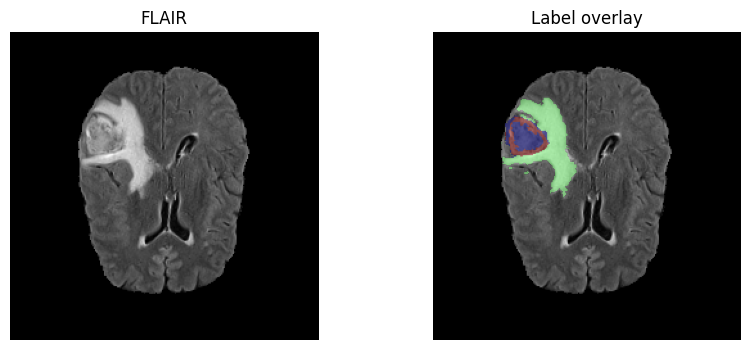

In [ ]:
def show_case_slice(imgs, label, slice_idx=None):
    # imgs: (4, H, W, D)
    flair = imgs[3]  # assuming 3 = FLAIR
    H, W, D = flair.shape
    if slice_idx is None:
        slice_idx = D // 2

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(flair[:, :, slice_idx].T, cmap="gray", origin="lower")
    plt.title("FLAIR")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(flair[:, :, slice_idx].T, cmap="gray", origin="lower")
    plt.imshow(np.ma.masked_where(label[:, :, slice_idx] == 0, label[:, :, slice_idx]).T,
               cmap="jet", alpha=0.5, origin="lower")
    plt.title("Label overlay")
    plt.axis("off")
    plt.show()

# Test on one case
example_id = test_ids[0]
imgs, label = load_case(example_id)
show_case_slice(imgs, label)


Intensity normalization

In [ ]:
def normalize_per_volume(vol, eps=1e-6):
    """
    Normalize a 3D volume to [0,1] using robust min/max (1st and 99th percentiles).
    """
    lo = np.percentile(vol, 1)
    hi = np.percentile(vol, 99)
    vol_clipped = np.clip(vol, lo, hi)
    vol_norm = (vol_clipped - lo) / (hi - lo + eps)
    return vol_norm

def normalize_modalities(imgs):
    """
    imgs: (4, H, W, D)
    Returns: normalized imgs in [0,1] per modality.
    """
    norm = np.zeros_like(imgs, dtype=np.float32)
    for m in range(imgs.shape[0]):
        norm[m] = normalize_per_volume(imgs[m])
    return norm

imgs_norm = normalize_modalities(imgs)


Define some simple drift transformations
We’ll start with three archetypes:

Brightness shift

Gaussian noise

Gaussian blur

We can later build more complex drifts on top.

In [ ]:
def drift_brightness(imgs, delta=0.1):
    """
    Add a constant brightness shift (delta) to all modalities.
    imgs: (M, H, W, D) in [0,1]
    """
    out = imgs + delta
    return np.clip(out, 0.0, 1.0)

def drift_gaussian_noise(imgs, sigma=0.05):
    """
    Add zero-mean Gaussian noise with std = sigma.
    imgs: (M, H, W, D) in [0,1]
    """
    noise = np.random.normal(0.0, sigma, size=imgs.shape).astype(np.float32)
    out = imgs + noise
    return np.clip(out, 0.0, 1.0)

def drift_gaussian_blur(imgs, sigma=1.0):
    """
    Apply 3D Gaussian blur separately to each modality.
    imgs: (M, H, W, D) in [0,1]
    """
    out = np.zeros_like(imgs)
    for m in range(imgs.shape[0]):
        out[m] = gaussian_filter(imgs[m], sigma=sigma)
    return np.clip(out, 0.0, 1.0)


Histogram + JS divergence utilities

We’ll implement:

1D histograms over intensities

JS divergence between two histograms

We can compute this per modality or joint across all modalities (start per modality; joint is more complex).

Create a mask (simple and effective)

Use non-zero voxels from any modality (FLAIR is best):

In [ ]:
def brain_mask_from_modality(vol):
    """
    Create a simple brain mask using non-zero intensities.
    Works for BraTS because background is exactly zero.
    """
    return vol > 0  # Returns boolean mask


Masked histogram function

In [ ]:
def compute_histogram_masked(vol, mask, bins=64, range=(0,1)):
    data = vol[mask]  # only brain voxels
    hist, _ = np.histogram(data, bins=bins, range=range)
    hist = hist.astype(float)
    if hist.sum() == 0:
        return np.ones(bins) / bins
    return hist / hist.sum()


Masked JS divergence per modality

In [ ]:
def modality_js_divergence_masked(imgs_ref, imgs_drift, mask, bins=64):
    js_vals = []
    for m in range(imgs_ref.shape[0]):
        p = compute_histogram_masked(imgs_ref[m], mask, bins=bins)
        q = compute_histogram_masked(imgs_drift[m], mask, bins=bins)
        js_vals.append(js_divergence(p, q))
    return js_vals


In [ ]:
def compute_histogram(vol, bins=64, range=(0, 1)):
    """
    Compute a normalized histogram over a 3D volume (or flattened multi-channel).
    Returns p (shape [bins], sums to 1).
    """
    hist, bin_edges = np.histogram(vol.ravel(), bins=bins, range=range, density=False)
    hist = hist.astype(np.float64)
    if hist.sum() == 0:
        return np.ones_like(hist) / len(hist)
    return hist / hist.sum()

def js_divergence(p, q, eps=1e-12):
    """
    Jensen-Shannon divergence between two discrete distributions p and q.
    p, q: arrays of shape [bins], sum to 1.
    """
    p = np.asarray(p, dtype=np.float64) + eps
    q = np.asarray(q, dtype=np.float64) + eps
    p /= p.sum()
    q /= q.sum()
    m = 0.5 * (p + q)
    kl_pm = np.sum(p * np.log(p / m))
    kl_qm = np.sum(q * np.log(q / m))
    js = 0.5 * (kl_pm + kl_qm)
    return js


In [ ]:
def modality_histograms_masked(imgs, mask, bins=64):
    """
    imgs: (M, H, W, D) in [0,1]
    mask: (H, W, D) boolean, same spatial shape
    Returns: list of histograms, one per modality, computed only in mask.
    """
    hists = []
    for m in range(imgs.shape[0]):
        hists.append(compute_histogram_masked(imgs[m], mask, bins=bins))
    return hists


def modality_js_divergence_masked(imgs_ref, imgs_drift, mask, bins=64):
    """
    Compute JS divergence per modality between reference and drifted images,
    restricted to the masked region (e.g. brain).
    """
    h_ref = modality_histograms_masked(imgs_ref, mask, bins=bins)
    h_drift = modality_histograms_masked(imgs_drift, mask, bins=bins)
    js_vals = [js_divergence(p, q) for p, q in zip(h_ref, h_drift)]
    return js_vals

JS divergence (masked) for FLAIR: 0.2610415282069304


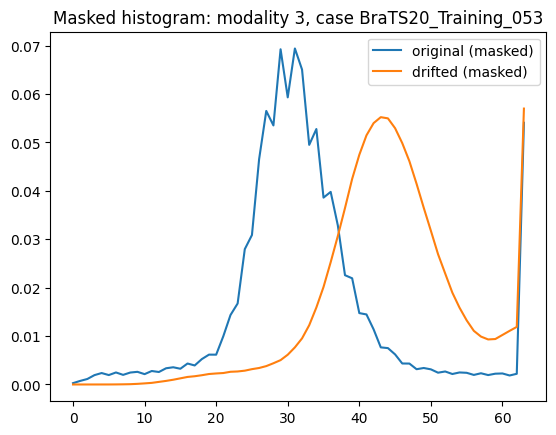

In [ ]:
case_id = test_ids[0]
imgs, label = load_case(case_id)
imgs_norm = normalize_modalities(imgs)

# Drift: brightness + noise
imgs_drift = drift_brightness(imgs_norm, delta=0.2)
imgs_drift = drift_gaussian_noise(imgs_drift, sigma=0.05)

# Create brain mask from FLAIR
mask = brain_mask_from_modality(imgs_norm[3])

# Compute masked histograms
hist_ref = compute_histogram_masked(imgs_norm[3], mask)
hist_drift = compute_histogram_masked(imgs_drift[3], mask)

# JS divergence
print("JS divergence (masked) for FLAIR:", js_divergence(hist_ref, hist_drift))

plt.plot(hist_ref, label="original (masked)")
plt.plot(hist_drift, label="drifted (masked)")
plt.title(f"Masked histogram: modality 3, case {case_id}")
plt.legend()
plt.show()


Run our first drift + JS experiment on one case

putting it all together on a single test case to make sure everything works.

In [ ]:
case_id = test_ids[0]
print("Using case:", case_id)

imgs, label = load_case(case_id)
imgs_norm = normalize_modalities(imgs)

# Create a drifted version: brightness + noise
imgs_drift = drift_brightness(imgs_norm, delta=0.2)
imgs_drift = drift_gaussian_noise(imgs_drift, sigma=0.05)

# Compute JS divergence per modality
js_vals = modality_js_divergence_masked(imgs_norm, imgs_drift, mask, bins=64)
print("JS divergence per modality [T1, T1ce, T2, FLAIR]:")
print(js_vals)


Using case: BraTS20_Training_053
JS divergence per modality [T1, T1ce, T2, FLAIR]:
[np.float64(0.13399324849398647), np.float64(0.17048067068938957), np.float64(0.23878626504355557), np.float64(0.260943924473212)]


Optionally visualize histograms for one modality to sanity check:

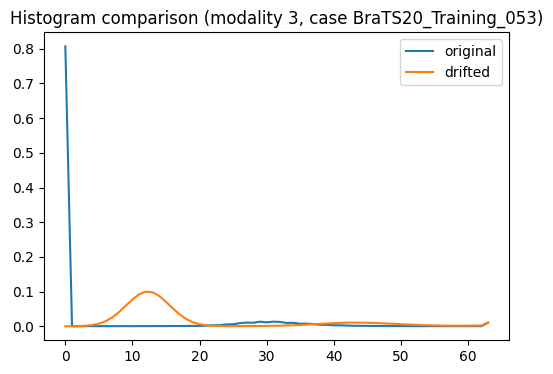

In [ ]:
# Example: FLAIR modality index = 3
m = 3
hist_ref = compute_histogram(imgs_norm[m], bins=64)
hist_drift = compute_histogram(imgs_drift[m], bins=64)

plt.figure(figsize=(6,4))
plt.plot(hist_ref, label="original")
plt.plot(hist_drift, label="drifted")
plt.title(f"Histogram comparison (modality {m}, case {case_id})")
plt.legend()
plt.show()
